# Random Forest Trained on ETC Parameters

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
from astropy.io import fits
import fitsio
from scipy import stats
import sys, os, warnings

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, train_test_split, KFold

# Load and Prepare Data

In [2]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/spectro/redux/daily/exposures-daily.fits'))
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='dark'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
mask &= cat['MJD'] != 0
cat = cat[mask]

In [3]:
# Select the specific columns we want
'''
INCLUDE:
Airmass
EBV
transparency
seeing
fiber-fracflux gfa
skymag all include g-r
efftime ga

'''
X = np.column_stack([
cat['EBV'],
cat['TRANSPARENCY_GFA'],
cat['SEEING_GFA'],
cat['SKY_MAG_R_SPEC'],
cat['SKY_MAG_G_SPEC']-cat['SKY_MAG_R_SPEC'],
])
y = np.column_stack([cat['EFFTIME_SPEC']/cat['EFFTIME_ETC']])
y = np.ravel(y)

0


Text(0.5, 0, 'Date (MJD)')

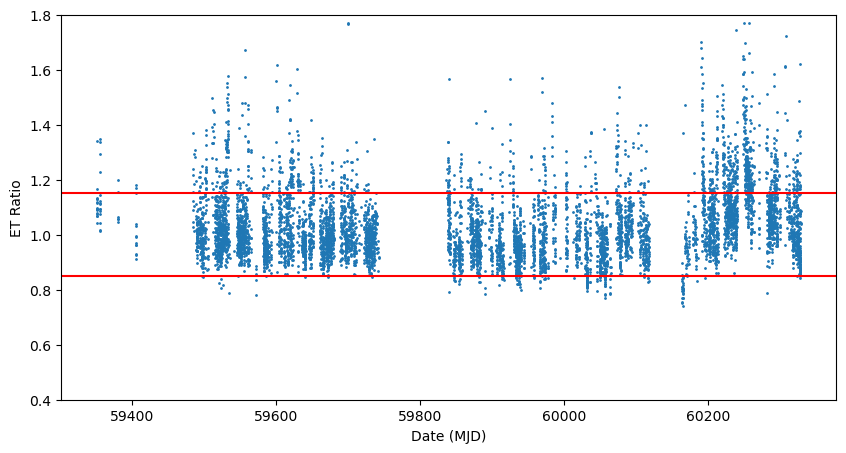

In [4]:
mask = cat['SURVEY']=='main'
mask &= cat['PROGRAM']=='dark'
mask &= cat['EFFTIME_ETC']>100
mask &= cat['EFFTIME_SPEC']>100
cat = cat[mask]
mask = cat['MJD']!=0
print(np.sum(~mask))
cat = cat[mask]

plt.figure(figsize=(10, 5))
plt.plot(cat['MJD'], cat['EFFTIME_SPEC']/cat['EFFTIME_ETC'], '.', ms=2)
plt.axhline(1.15, color='r')
plt.axhline(0.85, color='r')
plt.ylim(0.4, 1.8)
plt.ylabel('ET Ratio')
plt.xlabel('Date (MJD)')


# Train the Random Forest Regressor

### Split the data 50/50 train/test

In [5]:
# Split the training and testing set 50/50
idx_train, idx_test = train_test_split(np.arange(len(cat)), test_size=0.5, random_state=6123)

# Train the random forest
regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
regrf.fit(X[idx_train], y[idx_train])

RandomForestRegressor(max_depth=50, n_estimators=50, n_jobs=4,
                      random_state=1456)

### Feature Importances

(array([1, 3, 2, 0, 4]),)


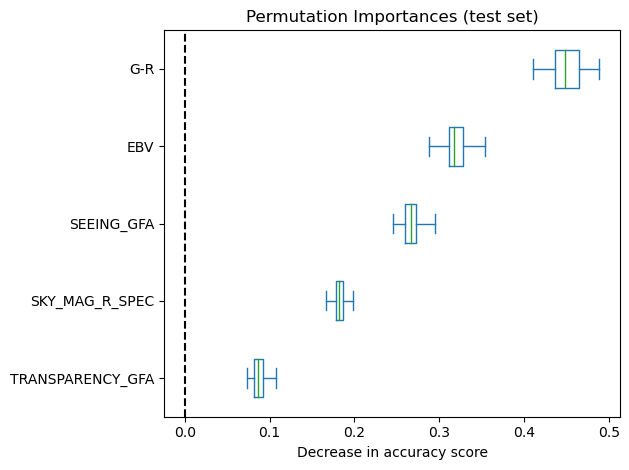

<Figure size 2500x2800 with 0 Axes>

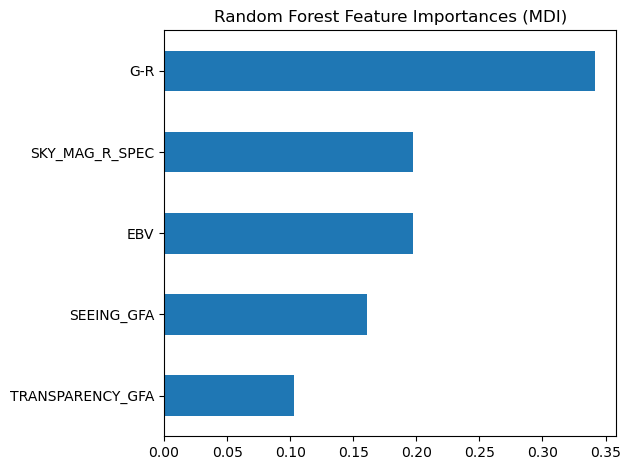

<Figure size 2500x2800 with 0 Axes>

In [6]:
from sklearn.inspection import permutation_importance
import pandas as pd

data = pd.DataFrame(columns=['EBV', 'TRANSPARENCY_GFA', 'SEEING_GFA','SKY_MAG_R_SPEC','G-R'])

result = permutation_importance(
    regrf, X[idx_test], y[idx_test], n_repeats=50, random_state=42, n_jobs=2
)
sorted_importances_idx = result.importances_mean.argsort()
sorted_importances_idx = sorted_importances_idx.astype(int),

print(sorted_importances_idx)
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=data.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.figure(figsize=(25,28))
plt.show()

# Vertical plot of the random forest importance
feature_names = ('EBV', 'TRANSPARENCY_GFA', 'SEEING_GFA','SKY_MAG_R_SPEC','G-R')

mdi_importances = pd.Series(
    regrf[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()
plt.figure(figsize=(25,28))
plt.show()

NMAD = 0.06322
Outlier fraction = 15.09%


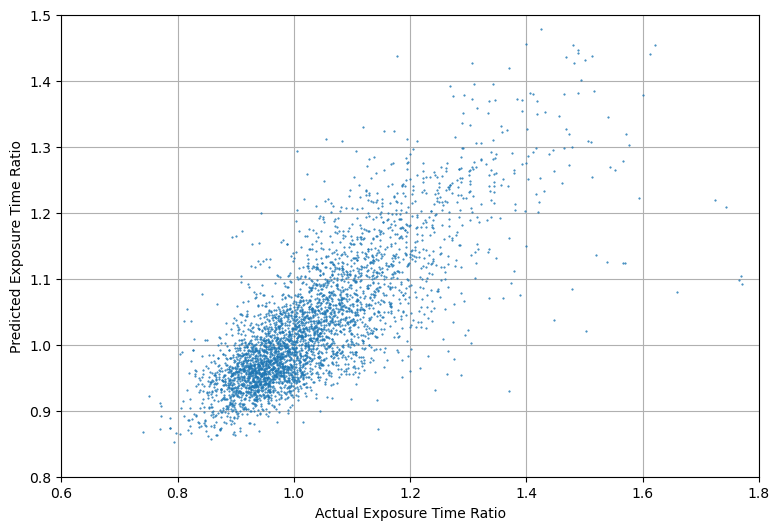

In [7]:
etratio_pred = regrf.predict(X[idx_test])
etratio_actu = y[idx_test]

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(9, 6))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

### 5 Fold Cross Validation

In [8]:
n_folds = 5
#kf createst the folds
kf = KFold(n_splits=n_folds, shuffle=True, random_state=1456)
np.random.seed(123)
etratio_pred = np.zeros(len(cat))

for kf_index, (idx_train, idx_test) in enumerate(kf.split(X)):
# there's a different idx_train and idx_test for each fold
    print('Fold %d'%(kf_index+1))
    regrf = RandomForestRegressor(n_estimators=50, max_depth=50, random_state=1456, n_jobs=4)
    regrf.fit(X[idx_train], y[idx_train])
    etratio_pred[idx_test] = regrf.predict(X[idx_test])

Fold 1
Fold 2
Fold 3
Fold 4
Fold 5


NMAD = 0.06153
Outlier fraction = 14.20%


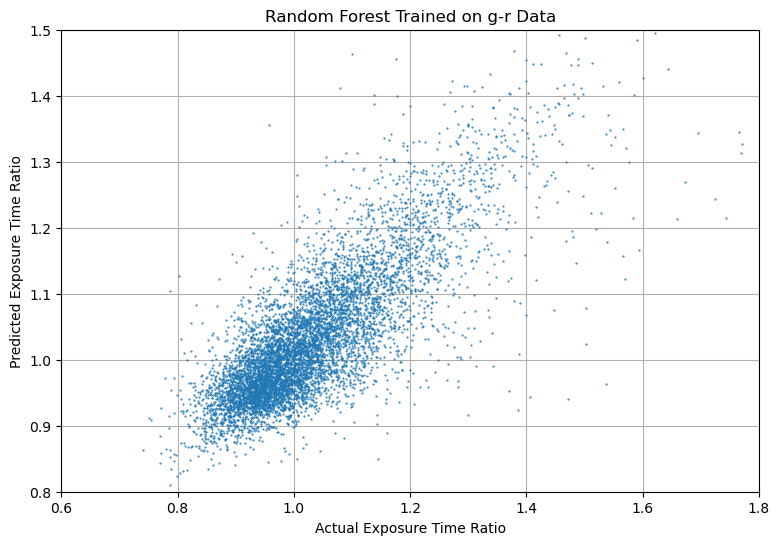

Mean Absolute Error 0.05557879400697386
Median Absolute Error 0.04157611933414063


In [9]:
etratio_actu = y

nmad = 1.48 * np.median(np.abs((etratio_pred - etratio_actu)))
outlier_threshold = 0.1
outlier_frac = np.sum(np.abs((etratio_pred - etratio_actu)) > outlier_threshold)/len(etratio_actu)
print('NMAD = {:.5f}'.format(nmad))
print('Outlier fraction = {:.2f}%'.format(outlier_frac*100))

plt.figure(figsize=(9, 6))
plt.plot(etratio_actu, etratio_pred, '.', markersize=1)
plt.title('Random Forest Trained on g-r Data')
plt.xlabel('Actual Exposure Time Ratio')
plt.ylabel('Predicted Exposure Time Ratio')
plt.axis([0.6, 1.8, 0.8, 1.5])
plt.grid()
plt.show()

from sklearn.metrics import mean_absolute_error, median_absolute_error
y=etratio_actu
y_pred = etratio_pred
print('Mean Absolute Error', mean_absolute_error(y, y_pred))
print('Median Absolute Error', median_absolute_error(y, y_pred))


# Optimize Random Forest Corrections

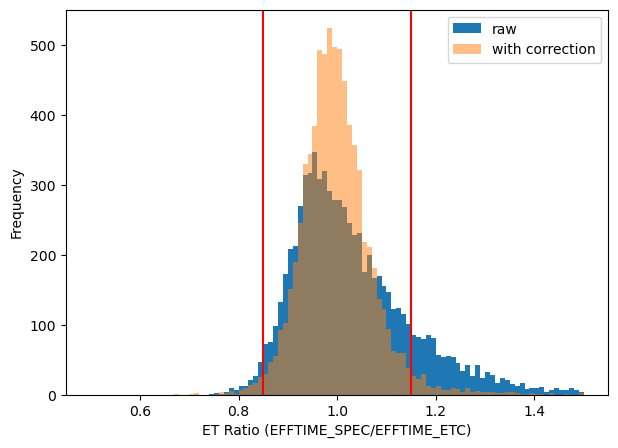

In [10]:
etratio_actu = y
cor_etratio = etratio_actu/etratio_pred

plt.figure(figsize=(7, 5))

plt.hist(etratio_actu,bins = 100,range=(0.5,1.5));
plt.hist(cor_etratio,bins = 100,range=(0.5,1.5), alpha = 0.5);
plt.legend(['raw', 'with correction'])
plt.axvline(0.85, color='r')
plt.axvline(1.15, color='r')


plt.xlabel('ET Ratio (EFFTIME_SPEC/EFFTIME_ETC)')
plt.ylabel('Frequency')

plt.show()

In [11]:
# function that counts the number of data points outside the 0.85-1.15 range in arr
def count_highs(arr):
    return (np.array(arr) > 1.15).sum()/len(arr)

def count_lows(arr):
    return (np.array(arr) < 0.85).sum()/len(arr)

In [12]:

def show_stats(arr, name): # takes in the array and the name of the data
    print('Statistics for', name)
    print('Fraction under 0.85:', count_lows(arr))
    print('Fraction over 1.15:', count_highs(arr))
    print('Median Absolute Deviation:', stats.median_abs_deviation(arr))
    print('Standard Deviation:', np.std(arr))
    print('-------------------------------')
    outliersraw = count_lows(etratio_actu)+count_highs(etratio_actu)
    outliersarr = count_lows(arr) + count_highs(arr)
    print('Outliers', outliersarr)
    print('Reduction in outliers from Raw Data:', outliersraw - outliersarr, "(", 1-outliersarr/outliersraw*100,"% less than raw)")
    print('Reduction in MAD from Raw Data:', stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr), "(", (stats.median_abs_deviation(etratio_actu) - stats.median_abs_deviation(arr))/stats.median_abs_deviation(etratio_actu) *100,"% less than raw)")
    print('Reduction in SD from Raw Data:', np.std(etratio_actu) - np.std(arr), "(", (np.std(etratio_actu) - np.std(arr))/np.std(etratio_actu) *100,"% less than raw)")

    print('-------------------------------')


In [13]:
show_stats(etratio_actu, "Raw Data")
print()
show_stats(etratio_actu/etratio_pred, "Unlimited Correction Data")
print()


Statistics for Raw Data
Fraction under 0.85: 0.019171470706529026
Fraction over 1.15: 0.1563212226840059
Median Absolute Deviation: 0.07020108213838228
Standard Deviation: 0.1330205406150333
-------------------------------
Outliers 0.17549269339053492
Reduction in outliers from Raw Data: 0.0 ( -99.0 % less than raw)
Reduction in MAD from Raw Data: 0.0 ( 0.0 % less than raw)
Reduction in SD from Raw Data: 0.0 ( 0.0 % less than raw)
-------------------------------

Statistics for Unlimited Correction Data
Fraction under 0.85: 0.0116637618983778
Fraction over 1.15: 0.027617643115699156
Median Absolute Deviation: 0.04005000073536025
Standard Deviation: 0.07394371114262747
-------------------------------
Outliers 0.03928140501407695
Reduction in outliers from Raw Data: 0.13621128837645796 ( -21.38349885408709 % less than raw)
Reduction in MAD from Raw Data: 0.03015108140302203 ( 42.94959633754277 % less than raw)
Reduction in SD from Raw Data: 0.05907682947240582 ( 44.411809784608 % less th